# Autoregressive Models

On this Notebook, some Autoregressive Models are tried in the job to solve the competition problem. The idea here is to find the most suitable model to use on an Ensemble with other constructed model.

## Libraries

In [216]:
import numpy as np 
import pandas as pd 
from cnr_methods import get_simplified_data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

from fbprophet import Prophet
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

## Data Extraction

In [217]:
full_data, full_label = get_simplified_data()

To simplify the analysis, let's work only with Training Data of Wind Farm 1.

In [218]:
X = full_data[full_data['Set']=='Train']
X = X[X['WF']=='WF3']
y = full_label[full_label.index.isin(X['ID'])]

## Facebook Prophet

The First method that will be tried is the Facebooks's Prophet. First thing to do is convert the data to the Standard Format required by Prophet.

In [219]:
y = y.reset_index()
y = y.merge(X.reset_index()[['Time','ID']],on='ID',how='left')
y = y[['Time','Production']]
y.columns = ['ds','y']

In [220]:
y.head()

,ds,y
0,2018-05-01 01:00:00,1.49
1,2018-05-01 02:00:00,2.48
2,2018-05-01 03:00:00,2.21
3,2018-05-01 04:00:00,1.49
4,2018-05-01 05:00:00,1.25


Let's divide the Data on Train and Hold Set. As the data has nearly 8 months of data, we'll separate the last month as the Holdout Set.

In [221]:
split = round(7*len(y)/8)

y_train = y[:split]
y_hold = y[split:]

Now, let's apply the Model.

In [222]:
m = Prophet(growth='logistic',n_changepoints=25,changepoint_prior_scale = 10000,yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=False)
#m.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=100)

In [223]:
y_train['floor'] = 0
y_train['cap'] = 10

In [224]:
m.fit(y_train)

In [225]:
future = m.make_future_dataframe(periods=780,freq='H',include_history=True)

In [226]:
future['floor'] = 0
future['cap'] = 10

In [227]:
forecast = m.predict(future)

In [228]:
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

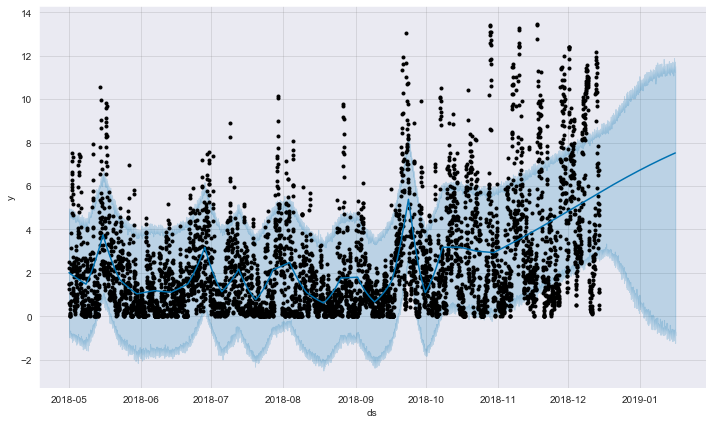

In [229]:
fig1 = m.plot(forecast)

In [230]:
preds = forecast[-780:]

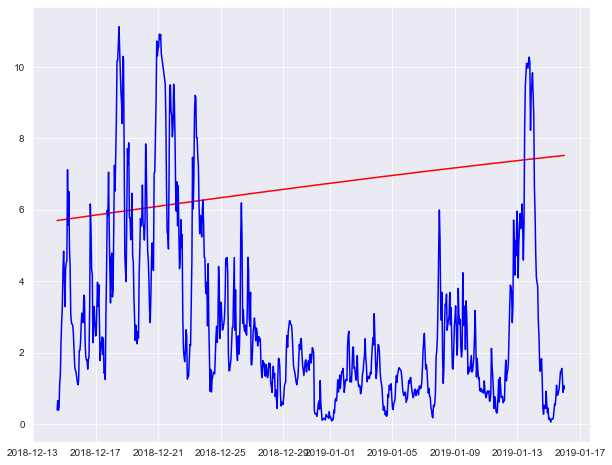

In [231]:
plt.figure(figsize=(10,8))
plt.plot(preds['ds'],preds['yhat'],'r',label='Predictions')
plt.plot(preds['ds'],y_hold['y'],'b',label='True Values')

## ARIMA

Here, we implement the ARIMA Model.

In [232]:
from scipy.stats import boxcox

In [233]:
y['y_boxcox'] = y['y'].clip(lower=0)
y['y_boxcox'] = y['y_boxcox'].replace({0:1e-6})
y['y_boxcox'] = boxcox(y['y_boxcox'])[0]

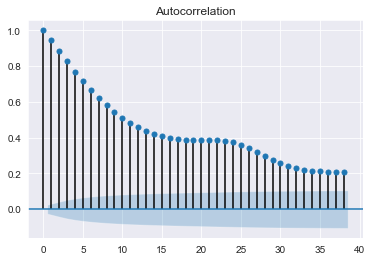

In [234]:
fig1 = plot_acf(y['y'])

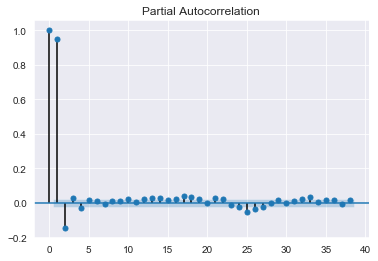

In [235]:
fig = plot_pacf(y['y'])

In [242]:
p = 2
d = 1
q = 5

In [243]:
model = ARIMA(y_train['y'], order=(p,d,q))

In [244]:
model_fit = model.fit(disp=0)
print(model_fit.summary())

ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 5458
Model:                 ARIMA(2, 1, 5)   Log Likelihood               -6626.923
Method:                       css-mle   S.D. of innovations              0.815
Date:                Wed, 10 Jun 2020   AIC                          13271.846
Time:                        15:27:41   BIC                          13331.290
Sample:                             1   HQIC                         13292.588
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.531      0.126      -0.000       0.001
ar.L1.D.y      0.1324      0.184      0.720      0.472      -0.228       0.493
ar.L2.D.y      0.6988      0.168      4.164      0.000       0.370       1.028
ma

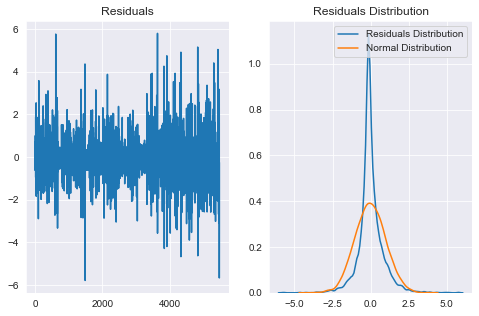

In [245]:
residuals = pd.DataFrame(model_fit.resid)
fig = plt.figure(figsize=(8,5))

plt.subplot(1,2,1)
plt.plot(residuals.index,residuals[0])
plt.title('Residuals')

plt.subplot(1,2,2)
sns.kdeplot(data=residuals[0],label='Residuals Distribution')
sns.kdeplot(data=np.random.normal(0,1,10000),label='Normal Distribution')
plt.title('Residuals Distribution')
plt.legend()

Text(0.5, 1.0, 'QQ-Plot')

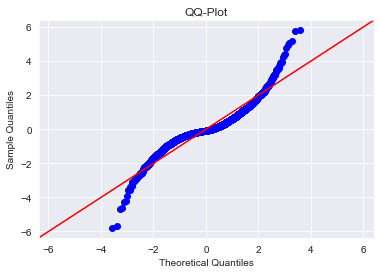

In [246]:
qqplot(residuals[0],line='45')
plt.title('QQ-Plot')

Text(0.5, 1.0, 'Autocorrelation')

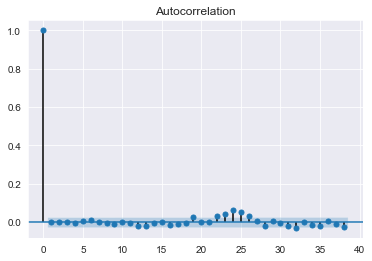

In [247]:
plot_acf(residuals[0])
plt.title('Autocorrelation')

In [248]:
fc, se, conf = model_fit.forecast(780, alpha=0.05)  # 95% conf

In [249]:
fc_series = pd.Series(fc, index=y_hold.index)
lower_series = pd.Series(conf[:, 0], index=y_hold.index)
upper_series = pd.Series(conf[:, 1], index=y_hold.index)

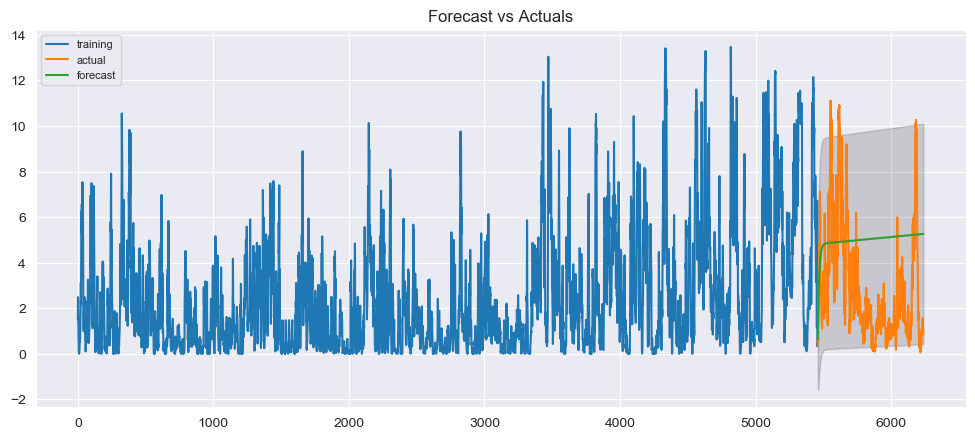

In [250]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train['y'], label='training')
plt.plot(y_hold['y'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

0/780
1/780
2/780
3/780
4/780
5/780
6/780
7/780
8/780
9/780
10/780
11/780
12/780
13/780
14/780
15/780
16/780
17/780
18/780
19/780
20/780
21/780
22/780
C:\Users\andre_\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
23/780
24/780
25/780
26/780
27/780
28/780
29/780
30/780
31/780
32/780
33/780
34/780
35/780
36/780
37/780
38/780
39/780
40/780
41/780
42/780
43/780
44/780
45/780
46/780
47/780
48/780
49/780
50/780
51/780
52/780
53/780
54/780
55/780
56/780
57/780
58/780
59/780
60/780
61/780
62/780
63/780
64/780
65/780
66/780
67/780
68/780
69/780
70/780
71/780
72/780
73/780
74/780
75/780
76/780
77/780
78/780
79/780
80/780
81/780
82/780
83/780
84/780
85/780
86/780
87/780
88/780
89/780
90/780
91/780
92/780
93/780
94/780
95/780
96/780
97/780
98/780
99/780
100/780
101/780
102/780
103/780
104/780
105/780
106/780
107/780
108/780
109/780
110/780
111/780
112/78

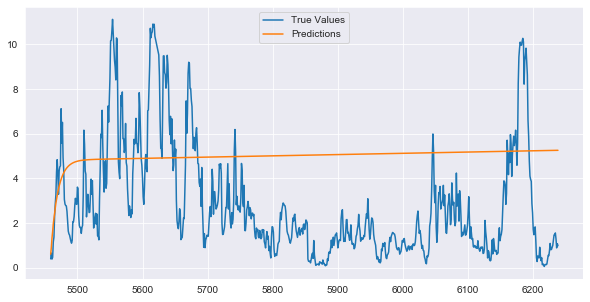

In [252]:
history = [x for x in y_train['y']]
predictions = []
for t in range(len(y_hold)):
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(yhat)
    print('{}/{}'.format(t,len(y_hold)))

plt.figure(figsize=(10,5))
plt.plot(y_hold.index,y_hold['y'],label='True Values')
plt.plot(y_hold.index,predictions, label='Predictions')
plt.legend()